In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

##  Load and Explore Dataset

In [109]:
# Load the datasets
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')

# Display basic information about the dataset
print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("\nFirst few rows of training data:")
print(train_df.head())



Training Data Shape: (54214, 4)
Test Data Shape: (54200, 3)

First few rows of training data:
   ID                             Title     Genre  \
0   1      Oscar et la dame rose (2009)     drama   
1   2                      Cupid (1997)  thriller   
2   3  Young, Wild and Wonderful (1980)     adult   
3   4             The Secret Sin (1915)     drama   
4   5            The Unrecovered (2007)     drama   

                                                                                           Description  
0  Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nob...  
1  A brother and sister with a past incestuous relationship have a current murderous relationship. ...  
2  As the bus empties the students for their field trip to the Museum of Natural History, little do...  
3  To help their unemployed father make ends meet, Edith and her twin sister Grace work as seamstre...  
4  The film's title refers not only to the un-recovered bodies

Genre Distribution:
Genre
drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
thriller        1591
action          1315
western         1032
reality-tv       884
family           784
adventure        775
music            731
romance          672
sci-fi           647
adult            590
Name: count, dtype: int64


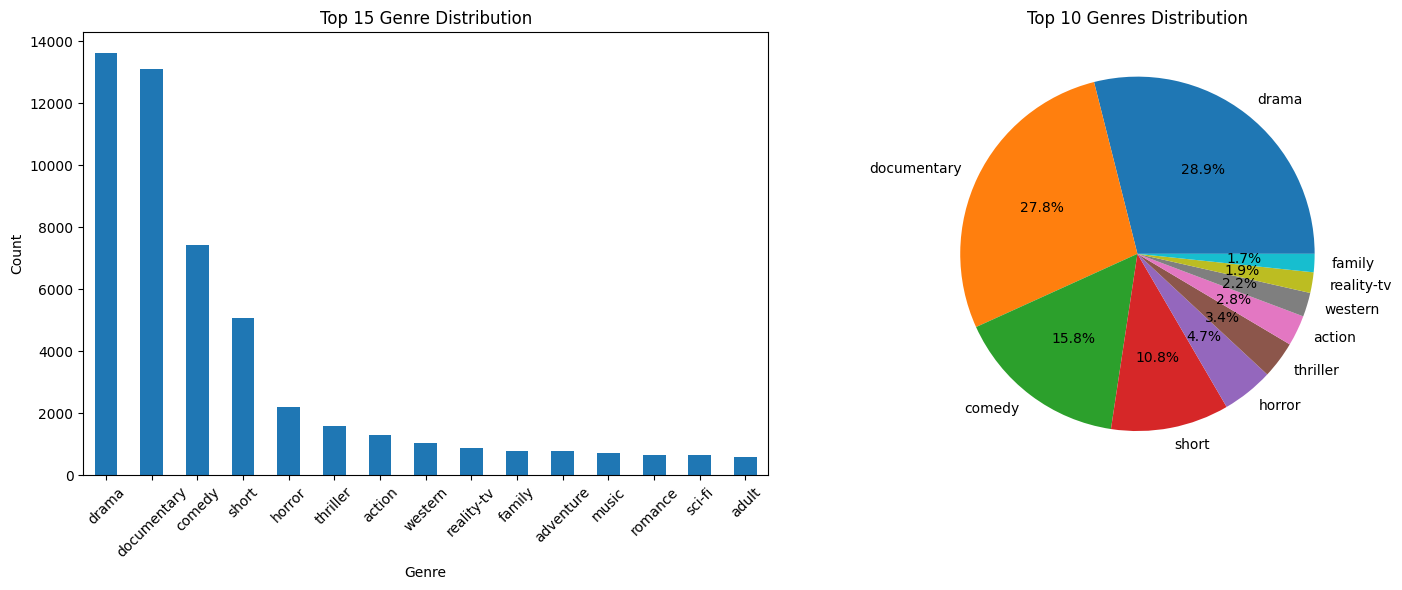

In [110]:
# Explore genre distribution
print("Genre Distribution:")
genre_counts = train_df['Genre'].value_counts()
print(genre_counts.head(15))

# Visualize genre distribution
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
genre_counts.head(15).plot(kind='bar')
plt.title('Top 15 Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(genre_counts.head(10).values, labels=genre_counts.head(10).index, autopct='%1.1f%%')
plt.title('Top 10 Genres Distribution')

plt.tight_layout()
plt.show()

## Data Preprocessing

In [111]:
# Remove rows with missing descriptions
print(f"Original training data shape: {train_df.shape}")
train_df = train_df.dropna(subset=['Description'])
print(f"After removing missing descriptions: {train_df.shape}")

# Remove duplicates
print(f"Duplicates before removal: {train_df.duplicated().sum()}")
train_df = train_df.drop_duplicates(subset=['Description'])
print(f"After removing duplicates: {train_df.shape}")

# Filter to top genres for better model performance (optional - keeps top 10 genres)
top_genres = train_df['Genre'].value_counts().head(10).index.tolist()
train_df_filtered = train_df[train_df['Genre'].isin(top_genres)].copy()

print(f"\nFiltered data shape (top 10 genres): {train_df_filtered.shape}")
print("Genres included:", top_genres)

Original training data shape: (54214, 4)
After removing missing descriptions: (54214, 4)
Duplicates before removal: 0
After removing duplicates: (54086, 4)

Filtered data shape (top 10 genres): (46937, 4)
Genres included: ['drama', 'documentary', 'comedy', 'short', 'horror', 'thriller', 'action', 'western', 'reality-tv', 'adventure']


In [112]:
def clean_text(text):
    if pd.isna(text):
        return ""
    
    text = text.lower()    
    text = re.sub(r'<.*?>', '', text)    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)    
    text = re.sub(r'[^a-zA-Z\s]', '', text)    
    text = ' '.join(text.split())    
    return text

sample_text = train_df_filtered['Description'].iloc[0]
print("Original text:")
print(sample_text[:200] + "...")
print("\nCleaned text:")
print(clean_text(sample_text)[:200] + "...")

Original text:
Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone...

Cleaned text:
listening in to a conversation between his doctor and parents yearold oscar learns what nobody has the courage to tell him he only has a few weeks to live furious he refuses to speak to anyone except ...


In [113]:
# Apply text cleaning to the dataset
train_df_filtered['cleaned_description'] = train_df_filtered['Description'].apply(clean_text)

# Remove empty descriptions after cleaning
train_df_filtered = train_df_filtered[train_df_filtered['cleaned_description'].str.len() > 0]
print(f"Final dataset shape after cleaning: {train_df_filtered.shape}")

Final dataset shape after cleaning: (46937, 5)


## TF-IDF Feature Engineering

In [114]:
# Prepare features and target
X = train_df_filtered['cleaned_description']
y = train_df_filtered['Genre']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target classes: {y.value_counts()}")

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,           
    ngram_range=(1, 2),          
    stop_words='english',        
    max_df=0.95,                 
    min_df=2                     
)

# Fit and transform the text data
print("Applying TF-IDF vectorization...")
X_tfidf = tfidf_vectorizer.fit_transform(X)

print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# Display some feature names
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Sample features: {feature_names[:20]}")

Features shape: (46937,)
Target shape: (46937,)
Target classes: Genre
drama          13572
documentary    13079
comedy          7429
short           5061
horror          2204
thriller        1590
action          1313
western         1032
reality-tv       882
adventure        775
Name: count, dtype: int64
Applying TF-IDF vectorization...
TF-IDF matrix shape: (46937, 5000)
Vocabulary size: 5000
Sample features: ['aaron' 'abandon' 'abandoned' 'abandons' 'abducted' 'abilities' 'ability'
 'able' 'aboard' 'abortion' 'abroad' 'absence' 'abstract' 'absurd' 'abuse'
 'abused' 'abusive' 'academic' 'academy' 'accept']


## Data Splitting

In [115]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain genre distribution in train/test splits
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

# Check genre distribution in splits
print("\nGenre distribution in training set:")
print(y_train.value_counts())
print("\nGenre distribution in test set:")
print(y_test.value_counts())

Training set shape: (37549, 5000)
Test set shape: (9388, 5000)
Training labels shape: (37549,)
Test labels shape: (9388,)

Genre distribution in training set:
Genre
drama          10857
documentary    10463
comedy          5943
short           4049
horror          1763
thriller        1272
action          1050
western          826
reality-tv       706
adventure        620
Name: count, dtype: int64

Genre distribution in test set:
Genre
drama          2715
documentary    2616
comedy         1486
short          1012
horror          441
thriller        318
action          263
western         206
reality-tv      176
adventure       155
Name: count, dtype: int64


## Train and Evaluation of Models

In [116]:
# Initialize and train Naive Bayes model
print("Training Naive Bayes model...")
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train, y_train)

# Make predictions
nb_predictions = nb_model.predict(X_test)

# Calculate accuracy
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")

# Get prediction probabilities for confidence scores
nb_probabilities = nb_model.predict_proba(X_test)


Training Naive Bayes model...
Naive Bayes Accuracy: 0.6010


In [117]:
# Initialize and train Logistic Regression model
print("Training Logistic Regression model...")
lr_model = LogisticRegression(
    max_iter=1000,          
    random_state=42,
    C=1.0                  
)
lr_model.fit(X_train, y_train)

# Make predictions
lr_predictions = lr_model.predict(X_test)

# Calculate accuracy
lr_accuracy = accuracy_score(y_test, lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

# Get prediction probabilities for confidence scores
lr_probabilities = lr_model.predict_proba(X_test)


Training Logistic Regression model...
Logistic Regression Accuracy: 0.6536


In [118]:
# Initialize and train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=100,       
    random_state=42,
    max_depth=20,          
    min_samples_split=5,    
    min_samples_leaf=2     
)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

rf_probabilities = rf_model.predict_proba(X_test)

Training Random Forest model...
Random Forest Accuracy: 0.5129


In [119]:
print("=== MODEL COMPARISON ===")
print(f"Naive Bayes Accuracy:      {nb_accuracy:.4f}")
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Random Forest Accuracy:    {rf_accuracy:.4f}")

# Store models and their performance
models = {
    'Naive Bayes': {'model': nb_model, 'accuracy': nb_accuracy, 'predictions': nb_predictions},
    'Logistic Regression': {'model': lr_model, 'accuracy': lr_accuracy, 'predictions': lr_predictions},
    'Random Forest': {'model': rf_model, 'accuracy': rf_accuracy, 'predictions': rf_predictions}
}

# Find best model
best_model_name = max(models.keys(), key=lambda x: models[x]['accuracy'])
best_model = models[best_model_name]['model']
print(f"\nBest performing model: {best_model_name}")

# Detailed classification reports
for model_name, model_info in models.items():
    print(f"\n=== {model_name.upper()} CLASSIFICATION REPORT ===")
    print(classification_report(y_test, model_info['predictions']))

=== MODEL COMPARISON ===
Naive Bayes Accuracy:      0.6010
Logistic Regression Accuracy: 0.6536
Random Forest Accuracy:    0.5129

Best performing model: Logistic Regression

=== NAIVE BAYES CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      action       0.72      0.11      0.19       263
   adventure       1.00      0.06      0.11       155
      comedy       0.61      0.44      0.51      1486
 documentary       0.66      0.87      0.75      2616
       drama       0.53      0.82      0.64      2715
      horror       0.76      0.34      0.47       441
  reality-tv       1.00      0.01      0.02       176
       short       0.65      0.13      0.21      1012
    thriller       0.54      0.02      0.04       318
     western       0.96      0.63      0.76       206

    accuracy                           0.60      9388
   macro avg       0.74      0.34      0.37      9388
weighted avg       0.63      0.60      0.55      9388


=== LOGISTIC REGRESSION

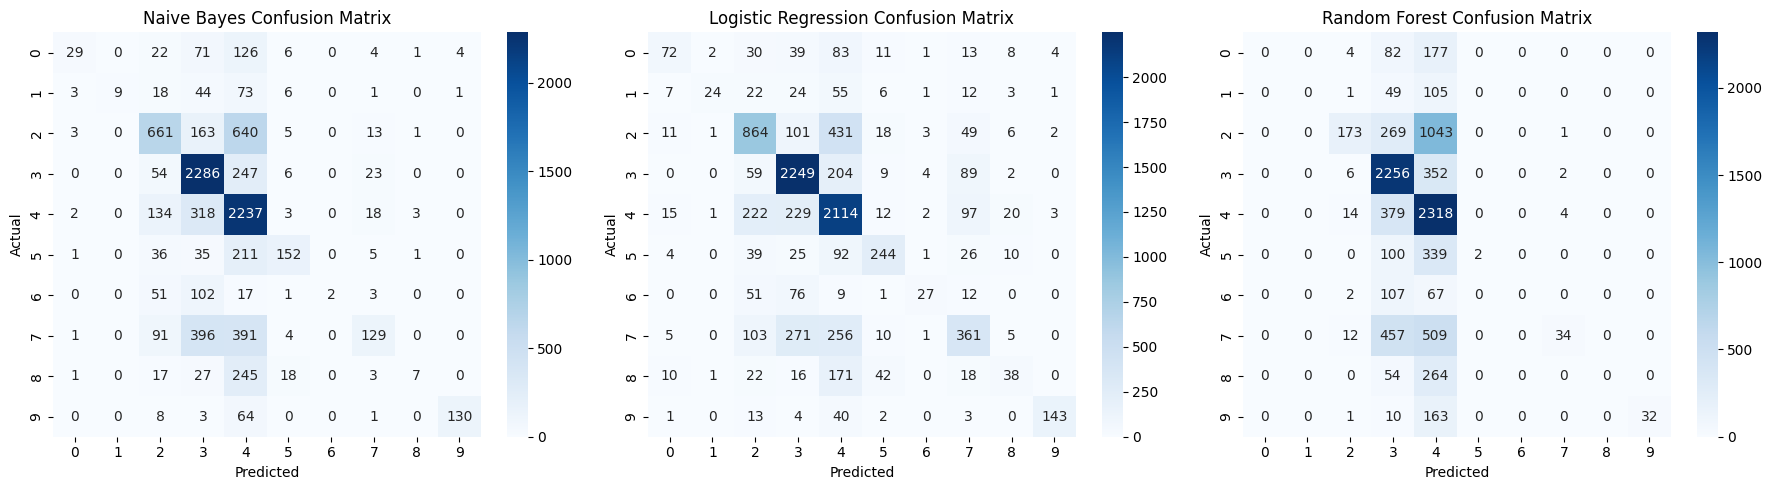

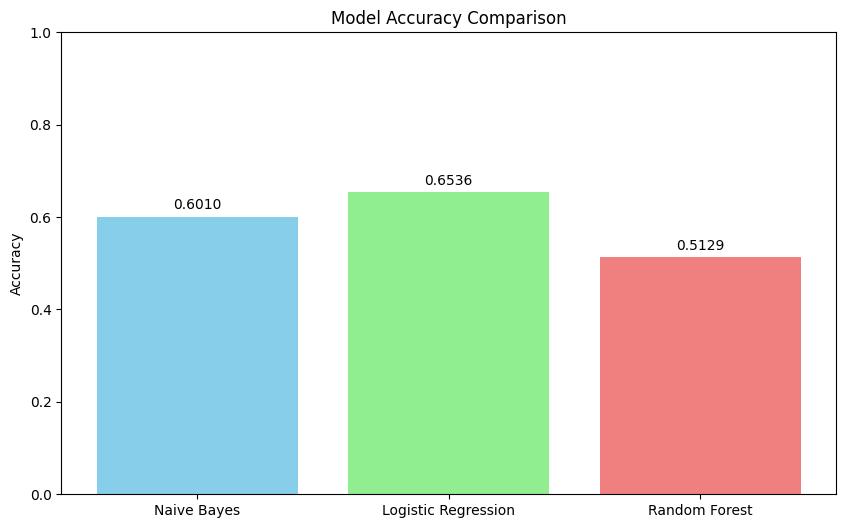

In [120]:
# Visualize confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (model_name, model_info) in enumerate(models.items()):
    cm = confusion_matrix(y_test, model_info['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{model_name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Model accuracy comparison chart
model_names = list(models.keys())
accuracies = [models[name]['accuracy'] for name in model_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add accuracy values on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.4f}', ha='center', va='bottom')

plt.show()

## Genre Prediction Functions

In [121]:
def predict_movie_genre(plot_summary, model=None, return_probabilities=True):
    if model is None:
        model = best_model
    
    cleaned_text = clean_text(plot_summary)    
    text_tfidf = tfidf_vectorizer.transform([cleaned_text])    
    predicted_genre = model.predict(text_tfidf)[0]    
    result = {'predicted_genre': predicted_genre}
    
    if return_probabilities:
        probabilities = model.predict_proba(text_tfidf)[0]
        class_labels = model.classes_        
        prob_dict = dict(zip(class_labels, probabilities))        
        sorted_probs = sorted(prob_dict.items(), key=lambda x: x[1], reverse=True)
        
        result['confidence_score'] = prob_dict[predicted_genre]
        result['all_probabilities'] = sorted_probs[:5]  
    
    return result

# Test the function
test_plot = """
A young wizard attends a school of magic and learns about his mysterious past. 
He discovers he is famous in the wizarding world and must face a dark wizard 
who killed his parents when he was a baby.
"""

prediction = predict_movie_genre(test_plot)
print("=== GENRE PREDICTION TEST ===")
print(f"Plot: {test_plot.strip()}")
print(f"Predicted Genre: {prediction['predicted_genre']}")
print(f"Confidence Score: {prediction['confidence_score']:.4f}")
print("Top 5 Predictions:")
for genre, prob in prediction['all_probabilities']:
    print(f"  {genre}: {prob:.4f}")

=== GENRE PREDICTION TEST ===
Plot: A young wizard attends a school of magic and learns about his mysterious past. 
He discovers he is famous in the wizarding world and must face a dark wizard 
who killed his parents when he was a baby.
Predicted Genre: drama
Confidence Score: 0.3692
Top 5 Predictions:
  drama: 0.3692
  thriller: 0.2037
  horror: 0.1831
  action: 0.0802
  short: 0.0680


In [122]:
# Test with multiple sample plot summaries
test_movies = [
    {
        "title": "Action Movie Example",
        "plot": "A retired special forces operative must save his kidnapped daughter from a group of international terrorists. Armed with special skills and determination, he fights through explosive action sequences and high-speed chases across the city."
    },
    {
        "title": "Horror Movie Example", 
        "plot": "A group of college students spend a weekend at an isolated cabin in the woods. Strange noises in the night lead to terrifying encounters with supernatural forces that threaten their lives."
    },
    {
        "title": "Comedy Movie Example",
        "plot": "Two bumbling friends accidentally become involved in a case of mistaken identity, leading to hilarious misunderstandings and comedic situations as they try to clear their names."
    },
    {
        "title": "Drama Movie Example",
        "plot": "A young woman struggles to overcome personal tragedy while caring for her aging father. Through emotional challenges and family conflicts, she discovers the strength to rebuild her life."
    },
    {
        "title": "Documentary Example",
        "plot": "This film explores the lives of endangered wildlife in their natural habitat, documenting the challenges they face and the conservation efforts being made to protect them."
    }
]

print("=== TESTING GENRE PREDICTION FUNCTION ===\n")

for movie in test_movies:
    print(f"Title: {movie['title']}")
    print(f"Plot: {movie['plot']}")
    
    # Test with all three models
    print("\nPredictions:")
    for model_name, model_info in models.items():
        prediction = predict_movie_genre(movie['plot'], model_info['model'], return_probabilities=False)
        print(f"  {model_name}: {prediction['predicted_genre']}")
    
    # Detailed prediction with best model
    detailed_prediction = predict_movie_genre(movie['plot'])
    print(f"\nBest Model ({best_model_name}) Detailed Results:")
    print(f"  Predicted Genre: {detailed_prediction['predicted_genre']}")
    print(f"  Confidence: {detailed_prediction['confidence_score']:.4f}")
    print("  Top 3 Predictions:")
    for genre, prob in detailed_prediction['all_probabilities'][:3]:
        print(f"    {genre}: {prob:.4f}")
    
    print("-" * 80)

=== TESTING GENRE PREDICTION FUNCTION ===

Title: Action Movie Example
Plot: A retired special forces operative must save his kidnapped daughter from a group of international terrorists. Armed with special skills and determination, he fights through explosive action sequences and high-speed chases across the city.

Predictions:
  Naive Bayes: action
  Logistic Regression: action
  Random Forest: drama

Best Model (Logistic Regression) Detailed Results:
  Predicted Genre: action
  Confidence: 0.9009
  Top 3 Predictions:
    action: 0.9009
    comedy: 0.0218
    drama: 0.0176
--------------------------------------------------------------------------------
Title: Horror Movie Example
Plot: A group of college students spend a weekend at an isolated cabin in the woods. Strange noises in the night lead to terrifying encounters with supernatural forces that threaten their lives.

Predictions:
  Naive Bayes: horror
  Logistic Regression: horror
  Random Forest: drama

Best Model (Logistic Regr